In [1]:
import requests
import pandas as pd
from io import BytesIO
import zipfile
import io
import os
import datetime
from pathlib import Path
import numpy as np
import sqlite3
from sqlalchemy import create_engine
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
multiplier=20
lot_size=75
limit=20*lot_size
STK_NAME = '"NIFTY"'
engine = create_engine('sqlite:///D:\\Freelance\\Nov-Dec\\Raghunath-Sir\\db\\foo.db' , echo=False)
query =  "SELECT * FROM users where ((INSTRUMENT='OPTIDX' OR INSTRUMENT='OPTSTK') AND (SYMBOL=" + str(STK_NAME) + ") AND (CONTRACTS * " + str(lot_size) + " > OPEN_INT * " + str(multiplier) + ") AND (OPEN_INT> "+ str(limit) +" )) "
queryResult = engine.execute(query).fetchall()
columnNames = engine.execute(" PRAGMA table_info(users) ")
temp = []
for row in columnNames:
    temp.append(dict(row))
columnNames = pd.DataFrame(temp)
columnNames = columnNames["name"]
finalResult = pd.DataFrame(queryResult)
finalResult = finalResult.rename(columns=columnNames)
finalResult = finalResult.drop(finalResult.columns[[0,-1]] , axis=1)

In [3]:
finalResult["NO_OF_DAYS_LEFT"]=0
finalResult['TIMESTAMP'] = finalResult['TIMESTAMP'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
finalResult['EXPIRY_DT'] = finalResult['EXPIRY_DT'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
finalResult["NO_OF_DAYS_LEFT"] = finalResult['EXPIRY_DT'] - finalResult['TIMESTAMP']

In [4]:
finalResult["PREV_CLOSE"]=0
finalResult["PREV_CONTRACTS"]=0

In [5]:
engine = create_engine('sqlite:///D:\\Freelance\\Nov-Dec\\Raghunath-Sir\\db\\foo.db' , echo=False)
query =  "SELECT * FROM users where INSTRUMENT='OPTIDX' AND SYMBOL=" + str(STK_NAME)
queryResult = engine.execute(query).fetchall()
columnNames = engine.execute(" PRAGMA table_info(users) ")
temp = []
for row in columnNames:
    temp.append(dict(row))
columnNames = pd.DataFrame(temp)
columnNames = columnNames["name"]
total = pd.DataFrame(queryResult)
total = total.rename(columns=columnNames)
total = total.drop(total.columns[[0,-1]] , axis=1)

In [6]:
total['TIMESTAMP'] = total['TIMESTAMP'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
total['EXPIRY_DT'] = total['EXPIRY_DT'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))

In [7]:
trading_days = pd.DataFrame(np.unique(total["TIMESTAMP"]))

In [8]:
for idx in finalResult.index:
    expiry = finalResult.loc[idx, "EXPIRY_DT"]
    strike = finalResult.loc[idx, "STRIKE_PR"]
    option_type = finalResult.loc[idx, "OPTION_TYP"]
    timestamp = finalResult.loc[idx, "TIMESTAMP"]
    index = np.where(trading_days == timestamp)
    index[0][0] -= 1
    if index[0][0] < 0:
        finalResult.loc[idx, "PREV_CLOSE"] = 0
        finalResult.loc[idx, "PREV_CONTRACTS"] = 0
    else:
        prev_timestamp_t = trading_days.loc[index[0][0]]
        prev_timestamp = prev_timestamp_t.loc[0]
        temp = total[(total["EXPIRY_DT"]==expiry) & (total["STRIKE_PR"]==strike) & (total["OPTION_TYP"]==option_type) & (total["TIMESTAMP"]==prev_timestamp)]
        if len(temp)==0:
            finalResult.loc[idx, "PREV_CLOSE"] = 0
            finalResult.loc[idx, "PREV_CONTRACTS"] = 0
        else:   
            finalResult.loc[idx, "PREV_CLOSE"] = temp.loc[temp.index[0],"CLOSE"]
            finalResult.loc[idx, "PREV_CONTRACTS"] = temp.loc[temp.index[0],"CONTRACTS"]

In [9]:
finalResult

,INSTRUMENT,SYMBOL,EXPIRY_DT,STRIKE_PR,OPTION_TYP,OPEN,HIGH,LOW,CLOSE,SETTLE_PR,CONTRACTS,VAL_INLAKH,OPEN_INT,CHG_IN_OI,TIMESTAMP,NO_OF_DAYS_LEFT,PREV_CLOSE,PREV_CONTRACTS
0,OPTIDX,NIFTY,2020-01-02,12150.0,CE,59.15,135.00,52.70,130.30,0.00,86711,795954.75,100575,-483525,2020-01-02,0 days,52.60,136542
1,OPTIDX,NIFTY,2020-01-02,12200.0,CE,28.00,84.75,16.95,79.55,0.00,583954,5363998.58,425550,-2325000,2020-01-02,0 days,21.80,517511
2,OPTIDX,NIFTY,2020-01-02,12250.0,CE,4.95,34.70,4.40,29.45,0.00,1164651,10714785.71,640425,-2044800,2020-01-02,0 days,7.90,341166
3,OPTIDX,NIFTY,2020-01-02,12300.0,PE,101.00,104.55,15.55,20.65,0.00,348027,3220578.26,493425,25350,2020-01-02,0 days,111.40,64083
4,OPTIDX,NIFTY,2020-01-02,12350.0,PE,138.05,142.00,65.40,69.45,0.00,15960,148905.61,47400,-48675,2020-01-02,0 days,159.70,5945
5,OPTIDX,NIFTY,2020-01-02,12400.0,PE,193.00,193.20,115.80,119.85,0.00,8364,78688.51,28350,-68025,2020-01-02,0 days,208.40,4847
6,OPTIDX,NIFTY,2020-01-09,12300.0,PE,73.00,134.00,65.00,108.70,108.70,148030,1377672.95,508050,-400650,2020-01-03,6 days,58.70,51597
7,OPTIDX,NIFTY,2020-01-09,12050.0,PE,23.25,102.35,21.65,88.70,88.70,170771,1552511.77,452700,54675,2020-01-06,3 days,15.15,57737
8,OPTIDX,NIFTY,2020-01-09,12100.0,PE,37.95,138.00,33.15,121.75,121.75,345599,3160002.44,763500,-664275,2020-01-06,3 days,23.55,241513
9,OPTIDX,NIFTY,2020-01-09,12050.0,CE,60.25,113.30,43.50,57.75,57.75,244879,2225188.34,770850,-226050,2020-01-07,2 days,47.20,153275


In [10]:
finalResult.to_csv("oi_volume.csv")

In [11]:
# INPUT INDEX FOR PLOTTING
index = 2000

In [12]:
expiry_date = finalResult.loc[index, "EXPIRY_DT"]
strike_price = finalResult.loc[index, "STRIKE_PR"]
option_type = finalResult.loc[index, "OPTION_TYP"]
plot_total = total[(total["EXPIRY_DT"]==expiry_date) & (total["STRIKE_PR"]==strike_price) & (total["OPTION_TYP"]==option_type)]
contracts = plot_total["CONTRACTS"]
close_price = plot_total["CLOSE"]
open_interest = plot_total["OPEN_INT"]
timestamp = plot_total["TIMESTAMP"]

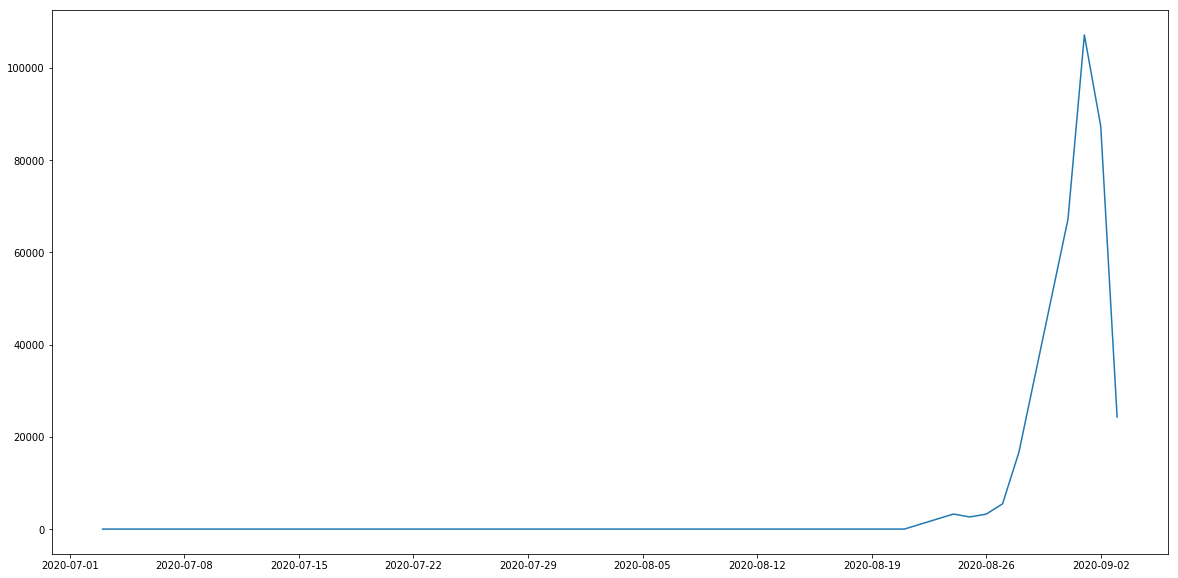

In [17]:
plt.figure(1,figsize=(20,10))
plt.plot(timestamp, contracts)

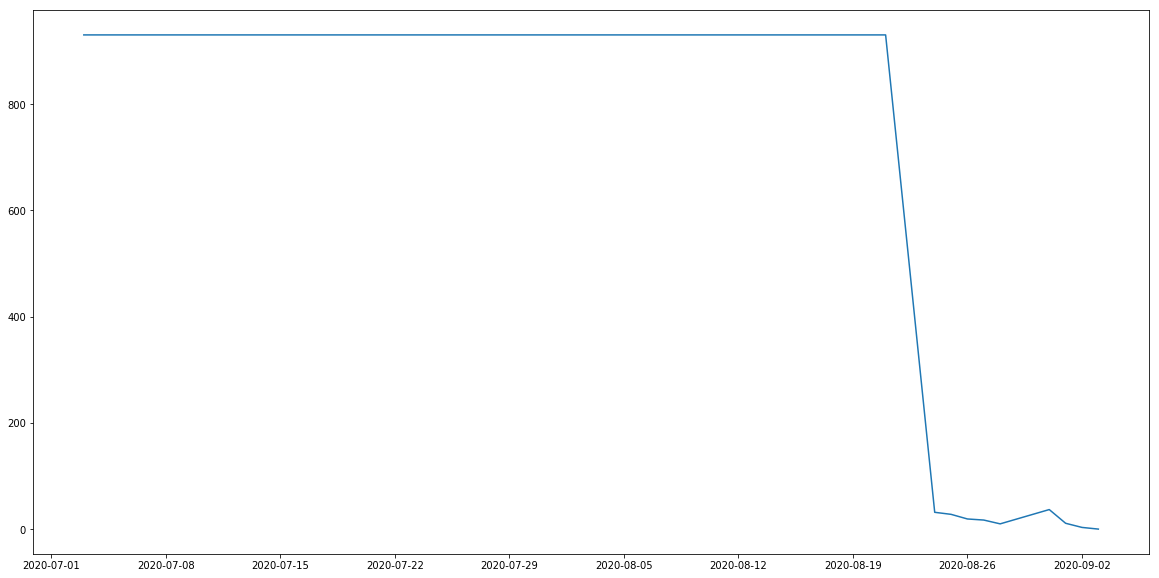

In [18]:
plt.figure(2,figsize=(20,10))
plt.plot(timestamp, close_price)

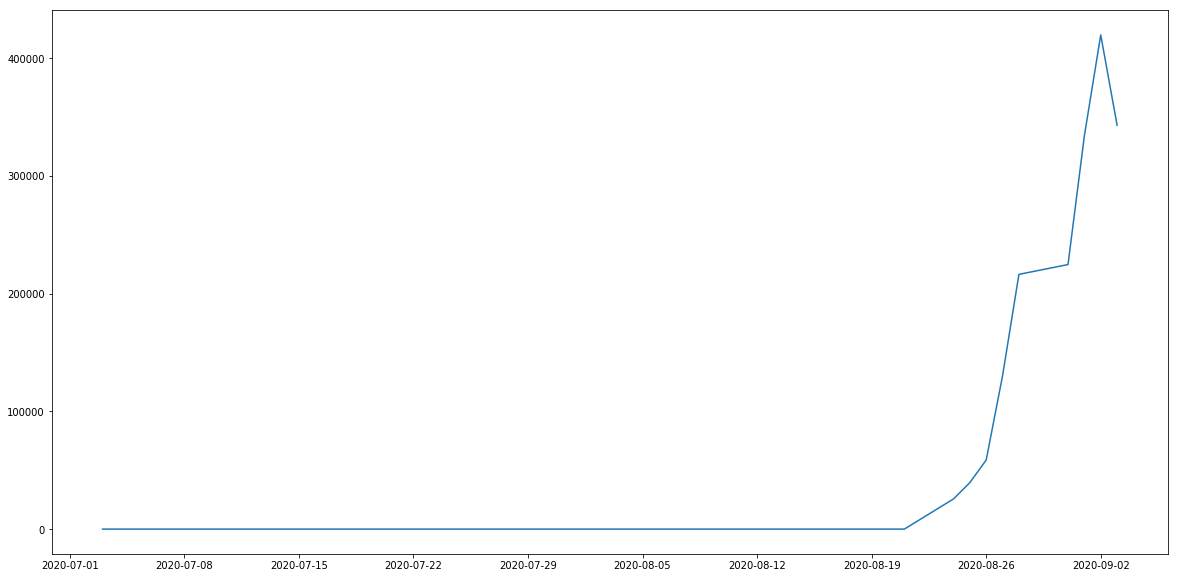

In [19]:
plt.figure(3,figsize=(20,10))
plt.plot(timestamp, open_interest)